# Creating a dynamic asset allocation strategy based on economic regime similarity
***
  1. Acquire & clean data
  2. EDA & feature engineering 
  3. **Create and test model**
  
## Review
So far, in Part 1, we have downloaded and cleaned all our publicly available data containing monthly economic features and daily asset returns.  In Part 2, we performed high level exploratory data analysis on our features and engineered additional series that we’ll use to train our model.  Because our algorithm will rank economic regime similarity based on a distance function, it was necessary for us to normalize the inputs.

Our data represents the time period between 1981-2019.  The goal was to train the model on a period that captures significant economic variability, but also test it over the course of a new economic cycle.  Thus, we used 1981-2005 as our training set and 2006-2019 as our test set.

## Quick note on theory
Portfolio construction is a heavily researched area within finance.  Since Modern Portfolio Theory became popularized in the 1950s, many other construction methods have been proposed, each with their own advantages and disadvantages.  As if construction weren’t hard enough, scoring or ranking investment results presents additional complications.  Traditionally, some function of reward per risk measure is used, with the Sharpe ratio being the most common metric.  

Maximizing the Sharpe ratio as a means of portfolio construction or a metric of portfolio returns has many well documented problems.  However, for the sake of simplicity, we will be using it for both in this project, amongst many other simplifications and assumptions.  The goal is to build out our framework in a straightforward way that easily allows for substitutions and room for growth, should we want to explore more advanced portfolio construction or return scoring methods.  Also, it is a good review of basic portfolio construction methodology and an opportunity to build out the code for the optimization and strategy testing. 



In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
#load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import datetime
from dateutil.relativedelta import relativedelta

from sklearn.neighbors import NearestNeighbors

import cvxpy as cp

import empyrical as emp
import time
from tabulate import tabulate



plt.style.use('seaborn')
%matplotlib inline

In [3]:
# import preprocessed features+returns
df_feat_train = pd.read_csv("../data/processed_features_train.csv",index_col=0,parse_dates=True)
returns_train = pd.read_csv("../data/processed_returns_train.csv",index_col=0,parse_dates=True)

df_feat_test = pd.read_csv("../data/processed_features_test.csv",index_col=0,parse_dates=True)
returns_test = pd.read_csv("../data/processed_returns_test.csv",index_col=0,parse_dates=True)

In [4]:
print(df_feat_train.shape)
print(returns_train.shape)

print(df_feat_test.shape)
print(returns_test.shape)


(299, 36)
(6222, 3)
(168, 36)
(3497, 3)


In [5]:
df_feat_train.head()
# daily series like 3m Rate is average across the month

,3M_Rate,10Y_2Y_Curve,5y5y_Forward,Core_PCE,NFP,UnEmp,Hstarts,IP,ISM,Mich_Sent,...,5y5y_Forward_changeZ,Core_PCE_changeZ,NFP_changeZ,UnEmp_changeZ,Hstarts_changeZ,IP_changeZ,ISM_changeZ,Mich_Sent_changeZ,Mich_Inf_changeZ,CPI_changeZ
1981-02-01,2.859565,-1.783853,2.079076,2.612643,-0.299608,0.736810,-0.322085,-0.929026,-0.559620,-1.536453,...,0.256197,-0.869377,-0.047696,-0.223419,-0.847384,0.147475,-0.024557,-0.478272,-0.742795,-0.031952
1981-03-01,2.464527,-1.491342,2.029175,1.667679,-0.140150,0.736810,-0.171012,0.550512,-0.421694,-1.568105,...,-0.242986,-1.160195,0.189423,-0.073279,0.234189,1.082222,0.112269,-0.012374,-1.187497,-0.003586
1981-04-01,2.555689,-1.511987,2.206714,2.125611,-0.294776,0.615336,-0.035045,-0.907460,-0.076880,-1.101231,...,0.194402,0.563036,-0.099459,-0.323018,0.205344,-1.014815,0.257805,0.777507,0.609657,0.392849
1981-05-01,3.276703,-2.465354,2.273855,2.369765,-0.584701,0.797546,-0.588982,0.649235,0.250693,-0.792619,...,-0.036160,0.281545,-0.264034,0.324261,-0.602971,1.191650,0.253903,0.558050,-0.631648,0.738219
1981-06-01,2.842990,-2.116706,2.083868,1.385256,0.289906,0.797546,-0.828182,0.464319,-0.232047,-1.045839,...,-0.462181,-1.189961,0.976957,-0.072768,-0.200444,-0.133152,-0.307470,-0.379208,-0.229768,-0.041721


In [6]:
returns_train.head()

,Stock_Returns,Bond_Returns,Commodity_Returns
1981-02-02,-0.020378,-0.008930,-0.013778
1981-02-03,0.012213,-0.006264,0.017889
1981-02-04,0.001012,0.007004,-0.010001
1981-02-05,0.008088,-0.004616,0.008622
1981-02-06,0.007483,-0.007331,0.022363


## Allocation Problem
For our problem, we assume the role of a constrained investor who needs to set an allocation strategy for the upcoming month.  Most of the progress in portfolio construction theory has come from using advanced techniques in analyzing historical returns to improve the parameter estimates for the future return distributions.   We are going to employ a slightly different approach.

While our implementation is mostly quantitative, our theory mirrors that of a macro investor.  Economic measures are clearly not independent nor are they identically distributed.  Asset indices, like those for stocks, bonds, or commodities, should have dependencies on the overall economic environment, despite their low signal to noise ratio. Our core approach is as follows:
   
> Rather than only analyze an arbitrarily fixed amount of historical returns data, we will subselect historical periods with the highest economic similarity to the current regime and construct our portfolio from this subset.

## Dynamic Algorithm
In practice, our dynamic algorithm will look like this:  
1. At the end of each new month $m_i$ of the test set, we compile all relevant economic indicators from the month and perform the appropriate feature transformations.
2. Calculate distance from $m_i$ to each historical month in the training set.
3. Subselect N nearest neighbor months based on distance into subset. 
4. Calculate mean and standard deviation of daily asset returns from subset. 
5. Calculate weights for historical max Sharpe portfolio and set as weights for next month, $m_{i+1}$

We will also apply the following investor constraints:
- No short sales
- No leverage
- Fully invested, (sum of weights = 1)
- Minimum position = 10%

In [7]:
# stock and commodity returns are negatively correlated to vol
# we will add filtering to algorithm
returns_train.resample('M').std().join(returns_train.resample('M').mean(),rsuffix='_mean',lsuffix='_std').corr()

,Stock_Returns_std,Bond_Returns_std,Commodity_Returns_std,Stock_Returns_mean,Bond_Returns_mean,Commodity_Returns_mean
Stock_Returns_std,1.000000,0.359024,0.233216,-0.272005,0.088358,-0.067148
Bond_Returns_std,0.359024,1.000000,-0.002791,-0.066617,0.074251,-0.098306
Commodity_Returns_std,0.233216,-0.002791,1.000000,-0.040414,-0.047669,-0.089793
Stock_Returns_mean,-0.272005,-0.066617,-0.040414,1.000000,0.161326,-0.021450
Bond_Returns_mean,0.088358,0.074251,-0.047669,0.161326,1.000000,-0.042045
Commodity_Returns_mean,-0.067148,-0.098306,-0.089793,-0.021450,-0.042045,1.000000


We are constrained to long only but know that periods of higher volatility are correlated to lower asset returns for stocks and commodities.  Because of our minimum position requirement, we can only reduce exposure up to a point so instead we will add a filter and opt for a minimized risk portfolio rather than maximum Sharpe during these periods.

Effectively, step 5 above turns into:
5. If any $\sigma_i$ >= $\sigma_{max}$ (kth percentile of asset return volatility in training set): Apply Min Variance Construction  
    Else: Apply Max Sharpe Construction 


In [8]:
# calculate max sigmas
max_r = returns_train['Stock_Returns'].rolling(21).std().quantile(.95)
max_c = returns_train['Commodity_Returns'].rolling(21).std().quantile(.95)

In [9]:
# define optimization functions
def cvx_opt(df):
    # converted sharpe maximization to standard quadratic program according to:
    # http://people.stat.sc.edu/sshen/events/backtesting/reference/maximizing%20the%20sharpe%20ratio.pdf
    
    # solve QP using cvxpy
    
    # define avg. returns and cov matrix
    u = np.asmatrix(df.values.mean(axis=0)).reshape(3,1)
    cov = np.cov(df.values.T)
    
    # define adjusted constraint matrix
    # min weight of each asset = .1
    A = np.asmatrix([[1,0,0],[0,1,0],[0,0,1]])
    bounds = np.asmatrix([0.1,.1,0.1])
    A_mod = A - bounds.T

    y = cp.Variable(len(cov))
    funct = cp.quad_form(y, cov)
    prob = cp.Problem(cp.Minimize(funct), 
                   [y@u == 1, 
                    y >= 0,  
                    A_mod@y.T >= 0 # additional linear constraints
                   ])
    r = prob.solve()
    
    if np.isinf(r):
        x = np.full((len(cov),),1/len(cov)) # equal weight, inf occurs if all mean returns are negative
    else:
        x = y.value/y.value.sum()

    return x

In [10]:
# Alternative function to calc weights for a min variance portfolio
def cvx_opt_minv(df):
    

    
    # define avg. returns and cov matrix
    u = np.asmatrix(df.values.mean(axis=0)).reshape(3,1)
    cov = np.cov(df.values.T)
    
    #set up bounds
    A = np.identity(len(cov))
    bounds = np.array([0.1,0.1,0.1])
    
    
    w = cp.Variable(len(cov)) 
    risk = cp.quad_form(w, cov)
    prob = cp.Problem(cp.Minimize(risk), # different objective function
                   [cp.sum(w) == 1, # sum =1
                    w >= 0,         # long only
                   A@w.T >= bounds])

    
    
    r = prob.solve()
    
    if np.isinf(r):
        x = np.full((len(cov),),1/len(cov)) # equal weight, inf occurs if all mean returns are negative
    else:
        x = w.value

    return x

In [11]:
# wrap everything together in class

class port_opt:
    
    def __init__(self,model):
        self.model = model
        self.wts = []
        self.wt0 = np.array([[.6,.3,.1]]).reshape(3,1)
        self.wts_opt = None
        self.OptimizeFunct_1 = None
        self.OptimizeFunct_2 = None
        self.d = []
        self.dst =[]
        self.nearest = None
        self.rets = None
        self.stds = None
        self.measures = None
        self.all_rets = None
        self.dailyM = None
        
        
        
    def predict_port(self,df_feat_train,df_feat_test,returns_train,returns_test,verbose=False):
        
        for i in range(len(df_feat_test)-1):
            self.dst, nearest = self.model.kneighbors([df_feat_test.values[i]],return_distance=True)

            # find similar N periods but get returns for the following month, mirrors what we are trying to do
            # use a mask to simplify the filter, a bit tough because features are monthly and returns daily
            mask = returns_train.index.strftime('%m-%Y').isin(df_feat_train.iloc[np.fmin(nearest+1,np.full((self.model.n_neighbors),[len(df_feat_train)-1]))[0],:].index.strftime('%m-%Y'))
            f = returns_train[mask]

            # check if greater than max std
            if np.any(returns_test.loc[df_feat_test.index[i].strftime('%m-%Y')].std() > [max_r,99,max_c]):
                if verbose:
                    print('min var: {}'.format(i))
                wt = self.OptimizeFunct_2(f)
            else:
                wt = self.OptimizeFunct_1(f)
            self.d.append(self.dst[0])
            self.wts.append(wt)
        self.d = np.array(self.d)
        self.wts = np.array(self.wts)
        return None
        
        
    # calc results for each test period and compare to static weight portfolios
    def calc_results(self):
        self.rets=[]
        self.stds=[]
        self.measures=[]
        self.all_rets=np.empty((0,3))
        self.dailyM=None

        for i in range(len(self.wts)):
            wts = np.asarray(self.wts[i]).reshape(3,1)
            next_month = df_feat_test.index[i] + relativedelta(months=1)
            next_month = datetime.datetime.strftime(next_month,'%m-%Y')

            ret = np.asarray(returns_test.loc[next_month].mean()).dot(wts)
            std = np.sqrt(wts.T.dot(returns_test.loc[next_month].cov().values).dot(wts))
            shrp = ret/std

            ret2 = returns_test.loc[next_month].mean().dot(self.wt0)
            std2 = np.sqrt(self.wt0.T.dot(returns_test.loc[next_month].cov().values).dot(self.wt0))
            shrp2 = ret2/std2

            ret3 = returns_test.loc[next_month].mean().dot(self.wts_opt)
            std3 = np.sqrt(self.wts_opt.T.dot(returns_test.loc[next_month].cov().values).dot(self.wts_opt))
            shrp3 = ret3/std3

            self.rets.append((ret[0],ret2[0],ret3))
            self.stds.append((std[0,0],std2[0,0],std3))
            self.measures.append((shrp[0,0],shrp2[0,0],shrp3))
            self.all_rets = np.concatenate((self.all_rets,np.column_stack([returns_test.loc[next_month].values.dot(wts),returns_test.loc[next_month].values.dot(self.wt0),returns_test.loc[next_month].values.dot(self.wts_opt)])))


        self.rets = np.array(self.rets)
        self.stds = np.array(self.stds)
        self.measures = np.array(self.measures)
        
        self.dailyM = np.mean(self.all_rets,axis=0)/np.std(self.all_rets,axis=0)
        
        return None
    
    def summary(self):
        
        strategy_list = ['','Dynamic Algo','Base: {}'.format(self.wt0.flatten()),'Training_Opt_Static']

        print(tabulate(
                [strategy_list,
                 ['CAGR',*list(emp.cagr(self.all_rets))],
                 ['Returns',*list(np.mean(self.all_rets,axis=0)*252)],
                 ['Std',*list(np.std(self.all_rets,axis=0)*np.sqrt(252))],
                 ['Sharpe',*list(self.dailyM*np.sqrt(252))],
                 ['Max Drawdown',*list(emp.max_drawdown(self.all_rets))],
                 ['Sortino',*list(emp.sortino_ratio(self.all_rets))],
                 ['Calmar',emp.calmar_ratio(self.all_rets[:,0]),emp.calmar_ratio(self.all_rets[:,1]),emp.calmar_ratio(self.all_rets[:,2])]
                ],
                headers="firstrow",tablefmt="github"))
        return None
    
    def plots(self):
        
        
        fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(16,28))
        

        l = len((np.insert((self.all_rets+1).cumprod(axis=0),0,1,axis=0)))
        ax1.plot(pd.DataFrame(index=returns_test.iloc[-l:].index,data=(np.insert((self.all_rets+1).cumprod(axis=0),0,1,axis=0))))
        ax1.set_title('Growth of a dollar')
        ax1.legend(loc='best',labels=['Dynamic Algo','Base: {}'.format(self.wt0.flatten()),'Training_Opt_Static'])

        l = len(emp.roll_max_drawdown(self.all_rets[:,0], window=252*1))

        datadf = pd.DataFrame({0:emp.roll_max_drawdown(self.all_rets[:,0], window=252*1),
                                1:emp.roll_max_drawdown(self.all_rets[:,1], window=252*1),
                                2:emp.roll_max_drawdown(self.all_rets[:,2], window=252*1)},
                             index = returns_test.iloc[-l:].index )

        ax2.plot(datadf)
        ax2.legend(loc='best',labels=['Dynamic Algo','Base: {}'.format(self.wt0.flatten()),'Training_Opt_Static'])
        ax2.set_title('Rolling 1y Max Drawdown')
        
        ax3.plot((pd.DataFrame(self.all_rets,index=returns_test.iloc[-len(self.all_rets):].index).rolling(252*3).apply(lambda x: x.mean()/x.std())*np.sqrt(252)).dropna())
        ax3.legend(labels=['Dynamic Algo','Base: {}'.format(self.wt0.flatten()),'Training_Opt_Static'])
        ax3.set_title('Rolling 3y Sharpe')
        
        r0 = pd.DataFrame(self.wts,index=df_feat_test.iloc[-len(self.wts):].index)
        ax4.stackplot(r0.index,r0.T)
        ax4.legend(loc='center right',labels=['Stock','Bond','Commodity'],bbox_to_anchor=(0,0))
        ax4.set_title('Dynamic Weights')
        
        return None

## Tuning & Training
The only hyperparameter we have to tune is the number of nearest neighbors, N, for the subset.  To do this, we break up our training set into several training and validation sets, leaving the test set untouched. 

Roughly, we want to choose a number of neighbors that gives us enough data to find a significant relationship through the noise but not too many that we trend towards using the parameters of the entire training set.

Additionally, we’d like to see stable performance such that N +/- a few neighbors doesn’t significantly impact the results (reduces overfitting).  

In [12]:
st = time.time()

X_train, X_val = df_feat_train.loc[:'1991'], df_feat_train.loc['1992':]
r2_train, r2_val = returns_train.loc[:'1991'], returns_train.loc['1992':]

out1 = []

for i in range(5, 61):

    tst1 = port_opt(NearestNeighbors())
    tst1.model.n_neighbors=i
    tst1.OptimizeFunct_1 = cvx_opt
    tst1.OptimizeFunct_2 = cvx_opt_minv
    tst1.wts_opt = tst1.OptimizeFunct_1(r2_train)
    tst1.model.fit(X_train.values)
    tst1.predict_port(X_train,X_val,r2_train,r2_val)
    tst1.calc_results()
    out1.append(tst1.dailyM*np.sqrt(252))

out1 = np.array(out1)


X_train, X_val = df_feat_train.loc[:'1993'], df_feat_train.loc['1994':]
r2_train, r2_val = returns_train.loc[:'1993'], returns_train.loc['1994':]

out2 = []

for i in range(5, 61):

    tst2 = port_opt(NearestNeighbors())
    tst2.model.n_neighbors=i
    tst2.OptimizeFunct_1 = cvx_opt
    tst2.OptimizeFunct_2 = cvx_opt_minv
    tst2.wts_opt = tst2.OptimizeFunct_1(r2_train)
    tst2.model.fit(X_train.values)
    tst2.predict_port(X_train,X_val,r2_train,r2_val)
    tst2.calc_results()
    out2.append(tst2.dailyM*np.sqrt(252))

out2 = np.array(out2)

X_train, X_val = df_feat_train.loc[:'1995'], df_feat_train.loc['1996':]
r2_train, r2_val = returns_train.loc[:'1995'], returns_train.loc['1996':]

out3 = []

for i in range(5, 61):

    tst3 = port_opt(NearestNeighbors())
    tst3.model.n_neighbors=i
    tst3.OptimizeFunct_1 = cvx_opt
    tst3.OptimizeFunct_2 = cvx_opt_minv
    tst3.wts_opt = tst3.OptimizeFunct_1(r2_train)
    tst3.model.fit(X_train.values)
    tst3.predict_port(X_train,X_val,r2_train,r2_val)
    tst3.calc_results()
    out3.append(tst3.dailyM*np.sqrt(252))

out3 = np.array(out3)

X_train, X_val = df_feat_train.loc[:'1997'], df_feat_train.loc['1998':]
r2_train, r2_val = returns_train.loc[:'1997'], returns_train.loc['1998':]

out4 = []

for i in range(5, 61):

    tst4 = port_opt(NearestNeighbors())
    tst4.model.n_neighbors=i
    tst4.OptimizeFunct_1 = cvx_opt
    tst4.OptimizeFunct_2 = cvx_opt_minv
    tst4.wts_opt = tst4.OptimizeFunct_1(r2_train)
    tst4.model.fit(X_train.values)
    tst4.predict_port(X_train,X_val,r2_train,r2_val)
    tst4.calc_results()
    out4.append(tst4.dailyM*np.sqrt(252))

out4 = np.array(out4)

endt = time.time()

print('runtime: {:.3f} mins'.format((endt-st)/60))

runtime: 17.952 mins


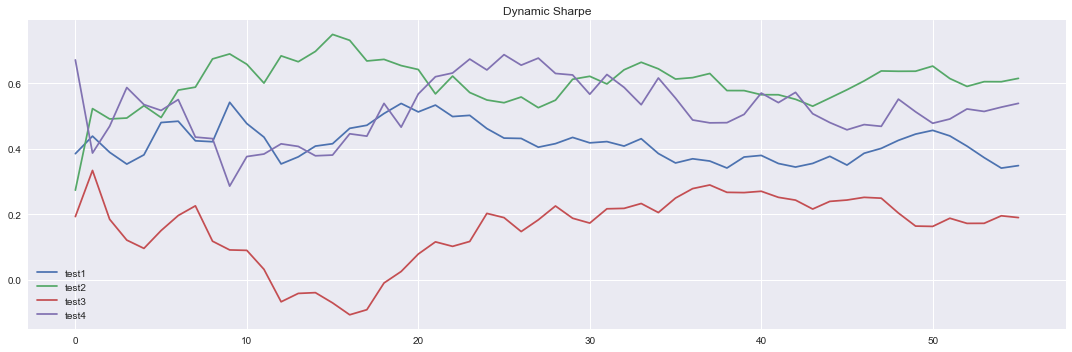

In [13]:
plt.figure(figsize=(15,5))

plt.plot(out1[:,0])
plt.plot(out2[:,0])
plt.plot(out3[:,0])
plt.plot(out4[:,0])
plt.title('Dynamic Sharpe')

plt.legend(['test1','test2','test3','test4'])

plt.tight_layout()


In [14]:
#choosing N = 36 months (3y).  Good mix of stability and success

In [15]:
out_final = []

i=36

final = port_opt(NearestNeighbors())
final.model.n_neighbors=i
final.OptimizeFunct_1 = cvx_opt
final.OptimizeFunct_2 = cvx_opt_minv
final.wts_opt = final.OptimizeFunct_1(returns_train)
final.model.fit(df_feat_train.values)
final.predict_port(df_feat_train,df_feat_test,returns_train,returns_test)
final.calc_results()
out_final.append(final.dailyM*np.sqrt(252))

out_final = np.array(out_final)

## Results
We compare the results of our dynamic algorithm against two traditional portfolios:
1. Base [0.6, 0.3, 0.1] is a 60% Stock, 30% Bond, 10% Commodity static allocation
2. Training_Opt_Static is a portfolio that uses the max Sharpe weights based on the entire training set

As seen below, our dynamic portfolio is attractive across a variety of metrics and has the highest Sharpe by a significant margin.

Interestingly, our dynamic portfolio even beats a max Sharpe portfolio constructed directly from the test set, had the returns been known ahead of time.  This ex-post portfolio represents the best possible Sharpe using a static weighting scheme under similar constraints and is helpful in putting the Sharpe from our Dynamic Algorithm into context. 


In [21]:
print('Training_Opt_Static weights: {:.3f} Stock,  {:.3f} Bond,  {:.3f} Commodity'.format(final.wts_opt[0],final.wts_opt[1],final.wts_opt[2]))

Training_Opt_Static weights: 0.132 Stock,  0.702 Bond,  0.167 Commodity


In [22]:
final.summary()

|              |   Dynamic Algo |   Base: [0.6 0.3 0.1] |   Training_Opt_Static |
|--------------|----------------|-----------------------|-----------------------|
| CAGR         |      0.0536106 |             0.0557123 |             0.0359974 |
| Returns      |      0.0543081 |             0.0609254 |             0.0370886 |
| Std          |      0.0645048 |             0.115692  |             0.058687  |
| Sharpe       |      0.841923  |             0.526617  |             0.631973  |
| Max Drawdown |     -0.133972  |            -0.385972  |            -0.168178  |
| Sortino      |      1.22893   |             0.733899  |             0.913838  |
| Calmar       |      0.400163  |             0.144343  |             0.214043  |


In [23]:
post_wts = cvx_opt(returns_test)
best = returns_test.mean().dot(post_wts)*np.sqrt(252) / (np.sqrt(post_wts.T.dot(returns_test.cov().values).dot(post_wts)))
print('Best Sharpe from ex-post returns: {:.3f}'.format(best))
print('Dynamic sharpe: {:.3f}'.format(out_final[0,0]))

Best Sharpe from ex-post returns: 0.819
Dynamic sharpe: 0.842


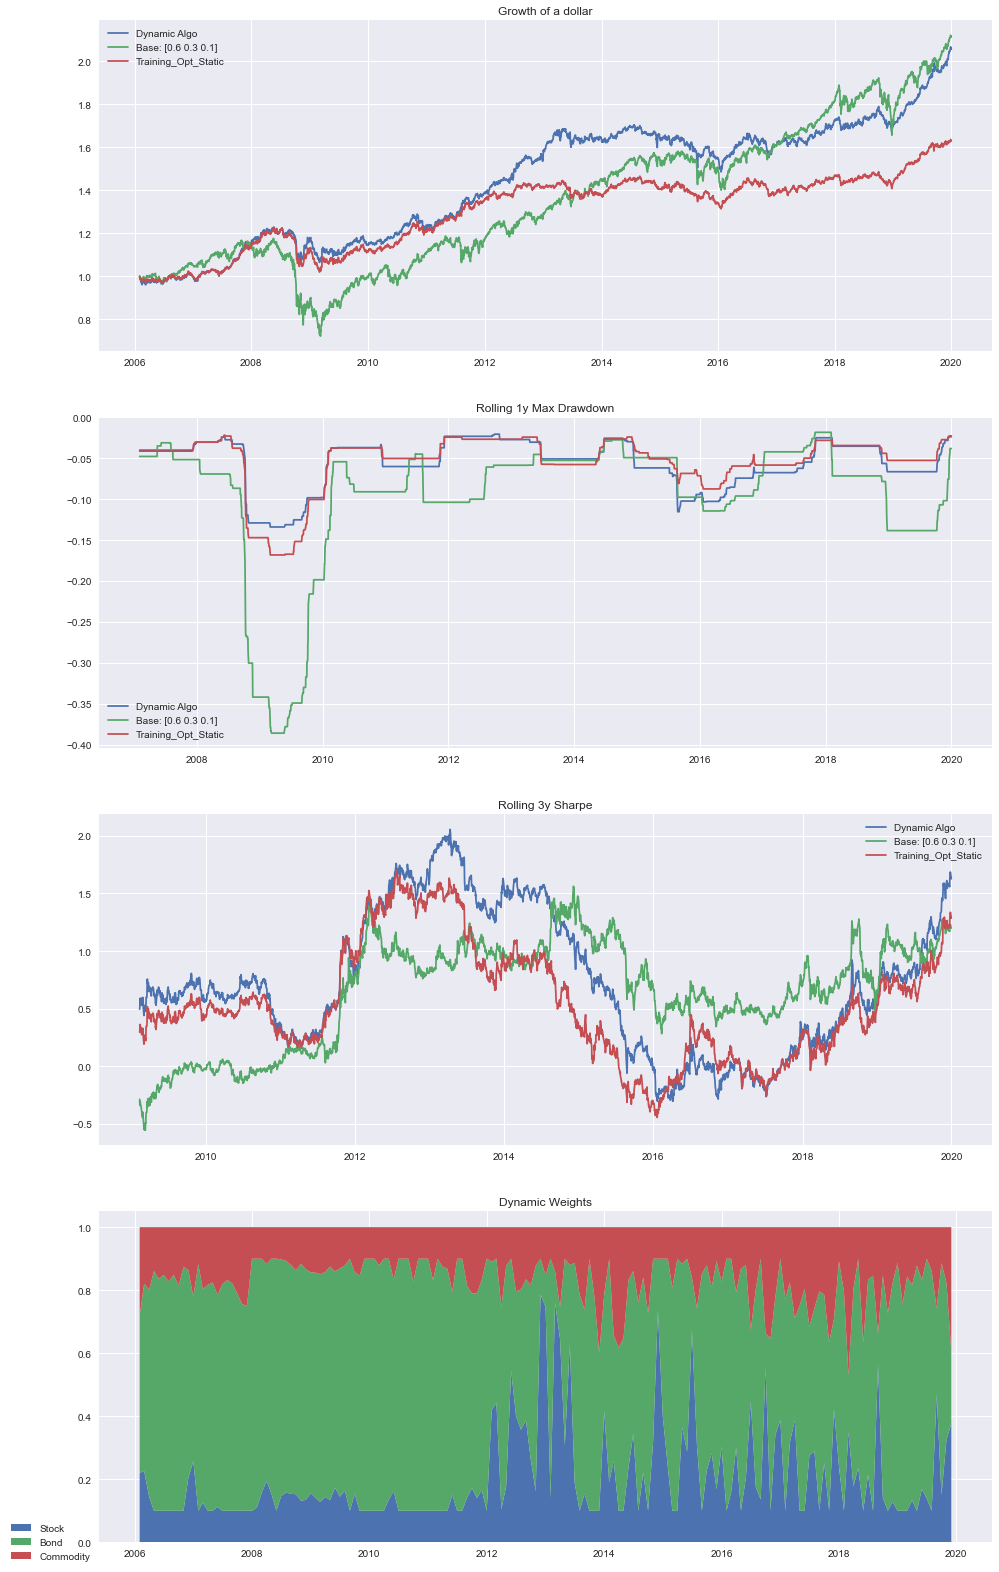

In [24]:
final.plots()

In [25]:
# last chart shows portfolio weights during each period, adds to 1, min 10%

# Ideas for Improvement
1. Expanding training window
2. Improve features and scaling
3. Include risk-free asset
4. Expand problem to clustering model, max sharpe within clusters, min std otherwise
5. Research different distance metrics
6. Create additional model to predict theoretical max sharpe, add as feature